# Classification of Cuisines using Recipe Ingredients - Classification Models

Food is a massive and complex arena in which culture, geography, climate, and social factors combine to create unique cuisines around the world. With the age of the internet, millions of recipes are now shared instantly and easily accessible. Many ingredients previously specific to certain regions of the world are now also widely available due to online commerce. This project aims to identify the signatures of particular cuisines.

### Objectives

For this section I will attempt to answer the following questions:

1. Can we build a predictive model that classifies cuisines based on their ingredients?

In [29]:
# import packages to read and work with data
import pandas as pd
import numpy as np
from collections import defaultdict
from random import shuffle, sample
import itertools
import time

# Visualization packages
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
sns.set(font_scale=1.5)

# Packages for working with text data
from nltk import tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

# Classification Model tools
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as fscore
from sklearn.model_selection import train_test_split

# Tools for Recommendations
from sklearn.neighbors import NearestNeighbors

In [2]:
# Load the cleaned dataset from the data folder
data = pd.read_pickle('data/data_clean.pkl')

# drop the words column of data
data.drop('words', axis=1, inplace=True)

# Convert the recipe ingredient lists into strings
ingredient_strings = [', '.join(recipe) for recipe in data.ingredients]
data.ingredients = ingredient_strings

In [3]:
# Custom tokenizer to separate list into tokens by commas
tokenized = tokenize.regexp.RegexpTokenizer(pattern=", ", gaps=True)

# Create TF-IDF weighting dictionary for each cuisine, exclude terms that appear in every cuisine
tfidf = TfidfVectorizer(tokenizer=tokenized.tokenize, max_df=0.12)

# Fit and transform cuisine ingredient lists to generate sparse matrix
ingredients_weighted = tfidf.fit_transform(data.ingredients)

In [4]:
ingredients_weighted

<39757x720 sparse matrix of type '<class 'numpy.float64'>'
	with 267634 stored elements in Compressed Sparse Row format>

Now that the sparse matrix is created, we will select splits for training, CV and test sets for our models.

In [5]:
# Split test set from data
X_temp, X_test, y_temp, y_test = train_test_split(ingredients_weighted, data.cuisine, test_size=0.2, random_state=42)

# Split remaining data into train and CV sets
X_train, X_CV, y_train, y_CV = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

# Verify train, CV and test sets
print('Number of training entries: {0} -> {1:.0f}% of data'.format(X_train.shape[0], 100*X_train.shape[0]/data.shape[0]))
print('Number of CV entries: {0} -> {1:.0f}% of data'.format(X_CV.shape[0], 100*X_CV.shape[0]/data.shape[0]))
print('Number of test entries: {0} -> {1:.0f}% of data'.format(X_test.shape[0], 100*X_test.shape[0]/data.shape[0]))

Number of training entries: 23853 -> 60% of data
Number of CV entries: 7952 -> 20% of data
Number of test entries: 7952 -> 20% of data


Now we can fit the recipes using our models. To start, I will use a dummy model to obtain a baseline performance that we can use for comparison with other models.

In [6]:
# Initialize Classification Models
dummy_clf = DummyClassifier()
nb_clf = MultinomialNB()
logreg_clf = LogisticRegression()
rf_clf = RandomForestClassifier()
ext_clf = ExtraTreesClassifier()
gb_clf = GradientBoostingClassifier()

In [7]:
dummy_clf.fit(X_train, y_train)
dummy_preds = dummy_clf.predict(X_CV)
print(classification_report(y_CV, dummy_preds))

              precision    recall  f1-score   support

   brazilian       0.01      0.01      0.01        85
     british       0.03      0.03      0.03       169
cajun_creole       0.03      0.03      0.03       299
     chinese       0.06      0.06      0.06       531
    filipino       0.01      0.01      0.01       150
      french       0.08      0.08      0.08       549
       greek       0.03      0.02      0.03       245
      indian       0.06      0.06      0.06       596
       irish       0.02      0.02      0.02       130
     italian       0.22      0.20      0.21      1621
    jamaican       0.01      0.01      0.01        92
    japanese       0.03      0.03      0.03       295
      korean       0.00      0.00      0.00       160
     mexican       0.16      0.17      0.16      1254
    moroccan       0.05      0.04      0.05       181
     russian       0.02      0.02      0.02       105
 southern_us       0.10      0.10      0.10       817
     spanish       0.03    

In [9]:
# Score dummy model
dummy_score = dummy_clf.score(X_test, y_test)
print('Overall accuracy of dummy model: {0:0.2f} %'.format(100*dummy_score))

Overall accuracy of dummy model: 9.76 %


In [10]:
def compare_models(models, model_names):
    scores_temp = []
    for i in range(len(models)):
        models[i].fit(X_train, y_train);
        preds = models[i].predict(X_CV);
        f1 = fscore(y_CV, preds, average='micro')[2]
        scores_temp.append(f1)
        print('{0} model average F1-score: {1:0.2f}'.format(model_names[i], f1))
    
    plt.subplots(figsize=(12,5))
    plt.bar(range(len(models)), scores_temp, edgecolor='k', color=sns.color_palette("tab10", n_colors=len(models)))
    plt.xticks(range(len(models)), model_names[:len(models)], rotation=30)
    plt.xlabel('Model')
    plt.ylabel('Averaged F1 Score')
    plt.title('Comparison of Model Performance')
    scores = scores_temp
    
    
    return plt.show(), list(scores)

Dummy model average F1-score: 0.10
Multinomial Naive Bayes model average F1-score: 0.69
Logistic Regression model average F1-score: 0.73
Random Forest model average F1-score: 0.66
Extremely Randomized Trees model average F1-score: 0.69
Gradient Boosting model average F1-score: 0.69


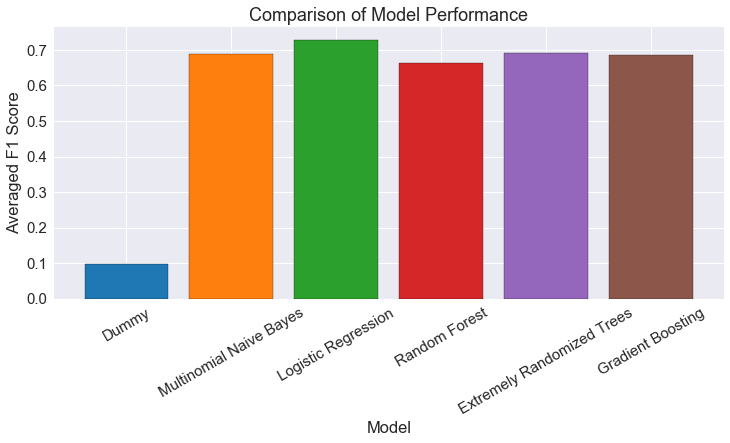

In [11]:
# Select our models
models = [dummy_clf, nb_clf, logreg_clf, rf_clf, ext_clf, gb_clf]
model_names = ['Dummy', 'Multinomial Naive Bayes', 'Logistic Regression',
               'Random Forest', 'Extremely Randomized Trees', 'Gradient Boosting']

# Performance comparison
_, scores = compare_models(models, model_names)

Looking at our baseline, it seems that Logistic Regression, Naive Bayes and Gradient Boosting models are the top performers, but we still require more optimization to get an idea of which model is most suitable for our data.

In [ ]:
# Create dictionary of class weights according to inverse of their distribution
weights = defaultdict(float)

# divide the total number of rows in the data by the number of rows for each cuisine to generate a weight value
for cuisine in data.cuisine.value_counts().index:
    weights[cuisine] = data.shape[0] / data[data.cuisine == cuisine].shape[0]

# test to see weight value
print(weights['italian'])

In [ ]:
# Optimized Classification Model parameters
nb_clf2 = MultinomialNB()

logreg_clf2 = LogisticRegression(solver='newton-cg', multi_class='multinomial',
                                 class_weight='balanced', max_iter=5000)

rf_clf2 = RandomForestClassifier(n_estimators = 2000, n_jobs=1,
                                 random_state=42, class_weight='balanced')

ext_clf2 = ExtraTreesClassifier(n_estimators = 2000, n_jobs=1,
                                random_state=42, class_weight='balanced')

gb_clf2 = GradientBoostingClassifier(n_estimators = 1000, random_state=42,
                                     max_features='auto')

optimized_models = [nb_clf2, logreg_clf2, rf_clf2, ext_clf2, gb_clf2]
optimized_model_names = model_names[1:]

In [ ]:
# Compare models with optimized parameters
t0 = time.time()

compare_models(optimized_models, optimized_model_names)

print('Total execution time : {0:0.1f} minutes'.format((time.time()-t0)/60.0))

In [9]:
# train the Extremely Randomized Trees Algorithm alone for final push in performance
ext_clf3 = ExtraTreesClassifier(n_estimators = 3000, n_jobs=1,
                                random_state=42, class_weight='balanced_subsample')

ext_clf3.fit(X_train, y_train);
preds = ext_clf3.predict(X_test);
print('Classification Report for Optimized Extremely Randomized Trees Algorithm:')
print(classification_report(y_test, preds))

Classification Report for Optimized Extremely Randomized Trees Algorithm:
              precision    recall  f1-score   support

   brazilian       0.55      0.43      0.48        87
     british       0.40      0.28      0.33       170
cajun_creole       0.74      0.70      0.72       327
     chinese       0.72      0.85      0.78       549
    filipino       0.70      0.42      0.52       153
      french       0.61      0.50      0.55       519
       greek       0.72      0.65      0.68       253
      indian       0.82      0.88      0.85       617
       irish       0.59      0.43      0.50       137
     italian       0.72      0.86      0.78      1525
    jamaican       0.76      0.70      0.73        99
    japanese       0.79      0.64      0.70       267
      korean       0.81      0.68      0.73       154
     mexican       0.83      0.88      0.86      1280
    moroccan       0.77      0.69      0.73       168
     russian       0.52      0.45      0.48        91
 southe

In [10]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    NOTE: This code was sourced from Sci-kit learn documentation,
    see: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html for more details
    """

    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

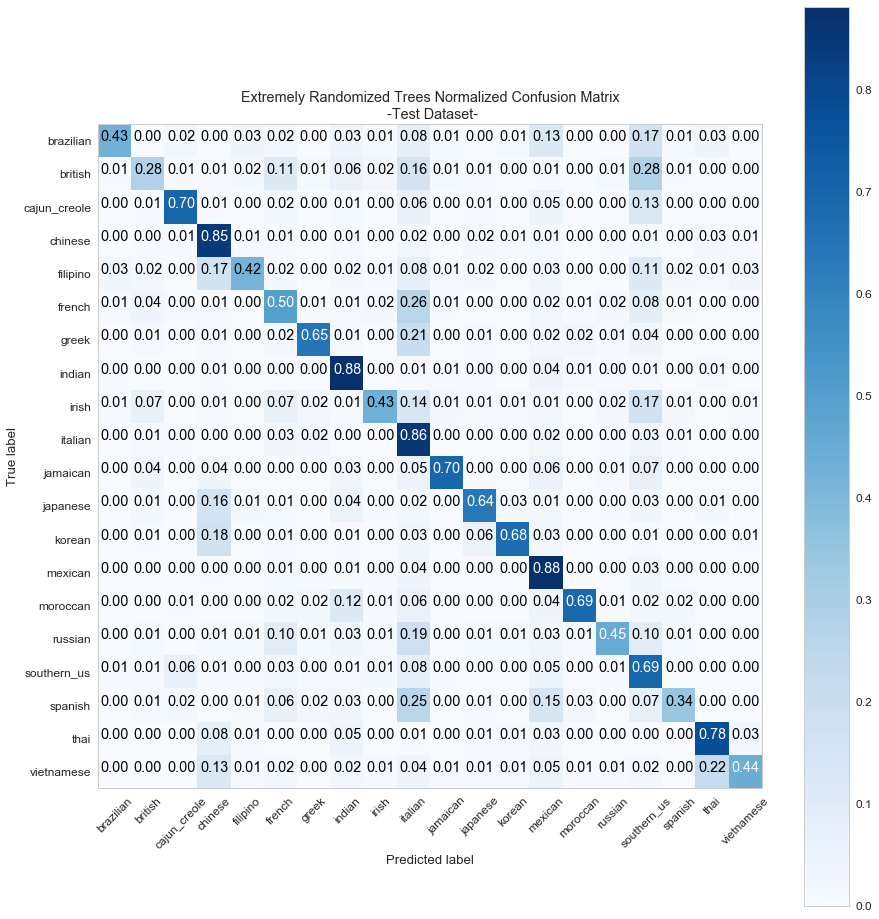

In [12]:
# Make predictions on test set
test_preds = ext_clf3.predict(X_test)

# Calculate confusion matrix for best model on test set
cnf_matrix = confusion_matrix(y_test, test_preds)

# Plot normalized confusion matrix
sns.set(font_scale=1.2)
sns.set_style("whitegrid",{'axes.grid' : False})
plt.figure(figsize = (13,13))
plot_confusion_matrix(cnf_matrix,
                      classes=ext_clf3.classes_,
                      normalize=True,
                      title='Extremely Randomized Trees Normalized Confusion Matrix\n -Test Dataset-')

plt.show()

In [13]:
final_score = ext_clf3.score(X_test, y_test)
print('Overall accuracy of best model: {0:0.2f} %'.format(100*final_score))

Overall accuracy of best model: 72.86 %
